**<font  size=7>SQL資料更新</font>**

In [1]:
####################################################################################################
#瘋狗流裝包
####################################################################################################
import pandas as pd
import numpy as np
import pyodbc
import warnings 
import warnings
warnings.filterwarnings("ignore")
from datetime import timedelta
import datetime
from interval3 import Interval, IntervalSet
from tqdm import tqdm
from scipy import stats
from importlib import reload
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from scipy import stats
from scipy import stats
from scipy.stats.mstats import winsorize
import os
warnings.filterwarnings("ignore")

from matplotlib.font_manager import FontProperties
# myfont=FontProperties(fname=r'C:\Users\chiehlinchen\Desktop\msj.ttf',size=14)
# # sns.set(font=myfont.get_family(), rc={'figure.figsize':(5,4)}, font_scale= 2)
# # sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
# plt.rcParams['axes.unicode_minus'] =False
plt.rcParams['axes.facecolor']='whitesmoke'

import plotly.express as px


In [3]:
####################################################################################################
#接數據庫
####################################################################################################


class get_df:

    def __init__(self):
        self.DB_infos = {"X01" : ("192.168.1.16", "X01", "cm23357868", "86875332")}
        self.querys = {}
        self.db = str()
        self.df_dict =  dict()
        self.w_code_dict = dict()
        self.point_dict = dict()
        self.result_dict = dict()
        
    def db_connect(self, DB_info):
        DB_Host, DB_Name, DB_User, DB_Password = self.DB_infos[DB_info]
        print("Connecting to database using pyodbc...")
        self.db = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server}; SERVER=' + DB_Host + '; DATABASE=' + DB_Name + '; UID=' + DB_User + '; PWD=' + DB_Password)
        print("Succesfully Connected to database using pyodbc!")
      
    def load_data(self, query):
        df =  pd.read_sql(self.querys[query], self.db)
        return df
    
    @staticmethod
    def make_fitable():
        sql_stock_price = """SELECT  [日期]
                                    ,[股票代號]
                                    ,[股票名稱]
                                    ,[資使用率]
                                    ,[融資維持率(%)]
                                    FROM [X01].[dbo].[日融資券排行] WITH(NOLOCK) where (len(股票代號) = 4 or 股票代號 IN ('TWA00','910322','910861','911608','911622','911868','912000')) and 日期 >= 20160101 order by 日期 """ 
        return sql_stock_price

    @staticmethod
    def make_stocktable():
        sql_stock_price = """SELECT  [日期]
                                    ,[股票代號]
                                    ,[股票名稱]
                                    ,[開盤價]
                                    ,[最高價]
                                    ,[最低價]
                                    ,[收盤價]
                                    ,[成交金額(千)]
                                    FROM [X01].[dbo].[日收盤表排行] WITH(NOLOCK)  where (len(股票代號) = 4 or 股票代號 IN ('TWA00','910322','910861','911608','911622','911868','912000')) and 日期 >= 20160101 order by 日期 """ 
        return sql_stock_price

    @staticmethod
    def make_returntable():
        sql_stock_price = """SELECT  [日期]
                                    ,[股票代號]
                                    ,[股票名稱]
                                    ,[還原收盤價]
                                    FROM [X01].[dbo].[日報酬率比較表] WITH(NOLOCK) where (len(股票代號) = 4 or 股票代號 IN ('TWA00','910322','910861','911608','911622','911868','912000')) and 日期 >= 20160101 order by 日期 """ 
        return sql_stock_price

    @staticmethod
    def make_toshintable():
        sql_stock_price = """SELECT  [日期]
                                    ,[股票代號]
                                    ,[股票名稱]
                                    ,[投信買賣超金額(千)]
                                    ,[投信持股比率(%)]
                                    ,[投信持股市值(百萬)]
                                    ,[投信持股成本]
                                    FROM [X01].[dbo].[日投信明細與排行] WITH(NOLOCK) where (len(股票代號) = 4 or 股票代號 IN ('TWA00','910322','910861','911608','911622','911868','912000')) and  日期 >= 20160101 order by 日期 """  
        return sql_stock_price

    @staticmethod
    def make_foregintable():
        sql_stock_price = """SELECT  [日期]
                                    ,[股票代號]
                                    ,[股票名稱]
                                    ,[外資買賣超金額(千)]
                                    ,[外資持股比率(%)]
                                    ,[外資持股市值(百萬)]
                                    ,[外資持股成本]
                                    FROM [X01].[dbo].[日外資持股與排行] WITH(NOLOCK) where (len(股票代號) = 4 or 股票代號 IN ('TWA00','910322','910861','911608','911622','911868','912000')) and  日期 >= 20160101 order by 日期 """ 
        return sql_stock_price

In [4]:
s_code_df = pd.read_excel(r'C:\Users\chiehlinchen\Desktop\ALLSTOCK.xlsx')
stock_ls = list(s_code_df.loc[0:,'NUM'])

In [5]:
Sql_Base = get_df()
Sql_Base.db_connect('X01')

Connecting to database using pyodbc...
Succesfully Connected to database using pyodbc!


In [6]:
Sql_Base.querys['日融資券排行'] = get_df.make_fitable()
fitable = Sql_Base.load_data('日融資券排行')

Sql_Base.querys['日收盤表排行'] = get_df.make_stocktable()
stocktable = Sql_Base.load_data('日收盤表排行')

Sql_Base.querys['日報酬率比較表'] = get_df.make_returntable()
returntable = Sql_Base.load_data('日報酬率比較表')

Sql_Base.querys['日投信明細與排行'] = get_df.make_toshintable()
toshintable = Sql_Base.load_data('日投信明細與排行')

Sql_Base.querys['日外資持股與排行'] = get_df.make_foregintable()
foregintable = Sql_Base.load_data('日外資持股與排行')

In [7]:
data_frame = stocktable.merge(fitable, on = ['日期','股票代號','股票名稱'], how = 'left').fillna(0)
data_frame = data_frame.merge(returntable, on = ['日期','股票代號','股票名稱'], how = 'left').fillna(0)
data_frame = data_frame.merge(toshintable, on = ['日期','股票代號','股票名稱'], how = 'left').fillna(0)
data_frame = data_frame.merge(foregintable, on = ['日期','股票代號','股票名稱'], how = 'left').fillna(0)
data_frame = data_frame[data_frame['股票代號'].isin(s_code_df['NUM'])]
data_frame['日期'] = pd.to_datetime(data_frame['日期'],format = "%Y%m%d").fillna(0)
data_frame = data_frame.set_index('日期')

data_dict = {str(stock_ls[i]):data_frame[data_frame['股票代號'] == stock_ls[i]] for i in tqdm(range(len(stock_ls)))}

feature_ls = data_frame.columns[2:]
data_frame = data_frame.reset_index(drop = False)
data_pivots_ls = []
for feature in tqdm(feature_ls):
    data_pivot = data_frame.pivot('日期','股票代號',feature)
    data_pivots_ls.append(data_pivot)
pivot_dict = {str(feature_ls[i]):data_pivots_ls[i] for i in range(len(feature_ls))}

data_dict.update(pivot_dict)

100%|██████████| 16/16 [00:13<00:00,  1.20it/s]


In [8]:
response1 = pd.read_excel(r'C:\Users\chiehlinchen\Desktop\ALLSTOCK.xlsx')
response1.index = response1.index+1
AS = response1['NUM']

response2 = pd.read_excel(r'C:\Users\chiehlinchen\Desktop\TCRINEW.xlsx')
response2.index = response2.index+1
SKTCRI = response2['NUM']

response3 = pd.read_excel(r'C:\Users\chiehlinchen\Desktop\STOCKFUTURE.xlsx')
response3.index = response3.index+1
SF = response3['NUM']


In [9]:
DDW = {}
for j in tqdm(AS):
    DDW[str(j)] = data_dict[str(j)].resample('W-FRI').agg({'開盤價':'first', '最高價':'max', '最低價':'min', '收盤價':'last','成交金額(千)':'sum','資使用率':'last','融資維持率(%)':'last', '還原收盤價':'last','投信持股比率(%)':'last','投信持股成本':'last','外資持股比率(%)':'last','外資持股成本':'last','投信持股市值(百萬)':'last'}).fillna(method = 'pad' ,axis = 0)

100%|██████████| 1776/1776 [00:18<00:00, 96.87it/s] 


**<font  size=7>計算大盤夏普</font>**

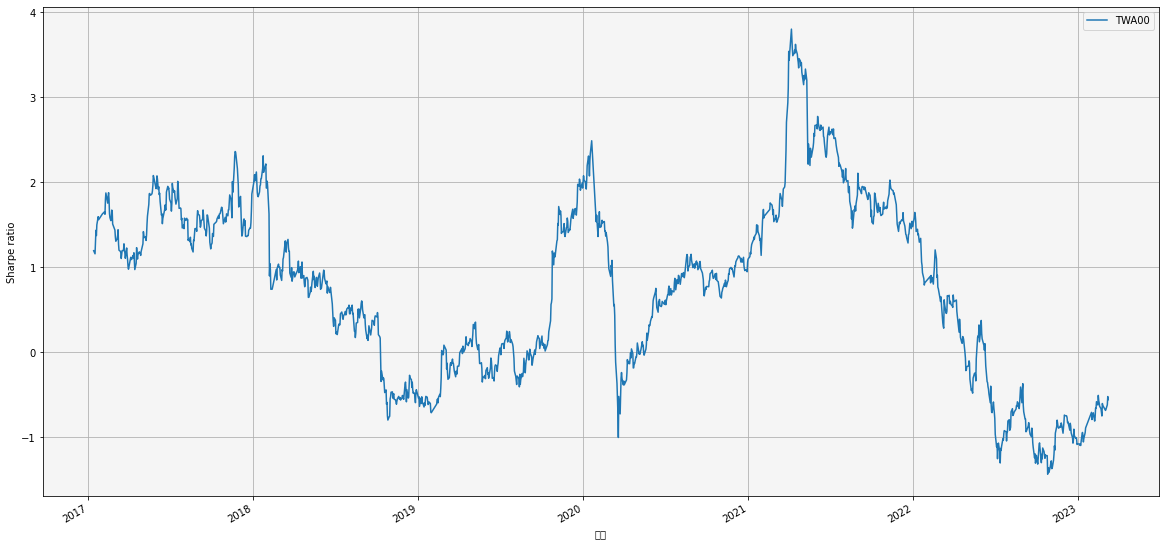

In [10]:
shar2 = pd.DataFrame()

change2 = data_dict["TWA00"]["還原收盤價"].pct_change()
sigma2 = change2.std()
data_dict["TWA00"]['rolling_ret'] = change2.rolling(252).mean()
data_dict["TWA00"]['rolling_std'] = change2.rolling(252).std()
data_dict["TWA00"]['sharpe'] = (data_dict["TWA00"]['rolling_ret'] / data_dict["TWA00"]['rolling_std']) * (252 ** 0.5)

APT2 = data_dict["TWA00"]["sharpe"]
APT2.name = 'TWA00'
DDW['TWA00']["sharpe"] = data_dict['TWA00']['sharpe'].groupby(pd.Grouper(freq='1W')).tail(1)
if len(shar2) == 0:
    shar2 = APT2
else:
    shar2 = pd.merge(shar2,APT2,left_on = shar2.index,right_on = APT2.index,how = 'outer')
    shar2.set_index('key_0',inplace = True)

plt.figure(figsize=(8,3))
plt.xlabel("time")
plt.ylabel("Sharpe ratio")
shar2.plot(figsize=(20, 10),label = "TWA00",grid = True)
plt.legend()

In [16]:
px.line(shar2.dropna())

**<font  size=7>計算大盤夏普</font>**

100%|██████████| 1776/1776 [02:19<00:00, 12.71it/s]


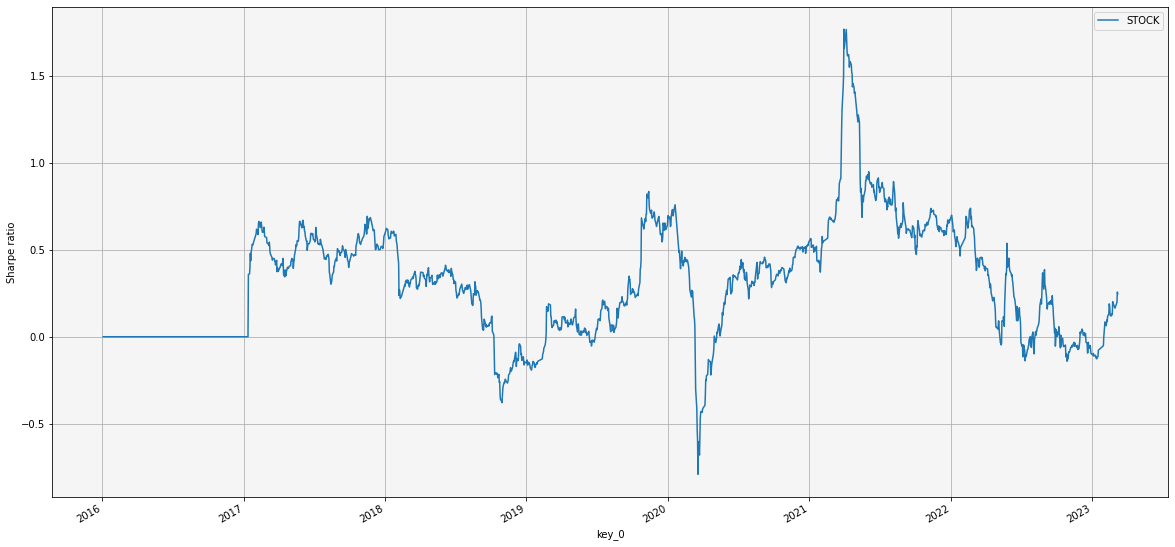

In [12]:
#Sharpe
shar = pd.DataFrame()

for i in tqdm(AS):
    change = data_dict[str(i)]["還原收盤價"].pct_change()
    sigma = change.std()
    data_dict[str(i)]['rolling_ret'] = change.rolling(252).mean()
    data_dict[str(i)]['rolling_std'] = change.rolling(252).std()
    data_dict[str(i)]['sharpe'] = (data_dict[str(i)]['rolling_ret'] / data_dict[str(i)]['rolling_std']) * (252 ** 0.5)

    APT = data_dict[str(i)]["sharpe"]
    APT.name = i

    if len(shar) == 0:
        shar = APT
    else:
        shar = pd.merge(shar,APT,left_on = shar.index,right_on = APT.index,how = 'outer')
        shar.set_index('key_0',inplace = True)

plt.figure(figsize=(8,3))
plt.xlabel("time")
plt.ylabel("Sharpe ratio")
wholesharpe = shar.sort_index().sum(axis = 1)/len(shar.columns)
wholesharpe.plot(figsize=(20, 10),label = "STOCK",grid = True)
plt.legend()
plt.savefig("一籃子夏普")

In [21]:
px.line(wholesharpe[wholesharpe!=0])

**<font  size=7>母關鍵點策略</font>**

100%|██████████| 1098/1098 [02:45<00:00,  6.62it/s]


Text(0, 0.5, 'Profit')

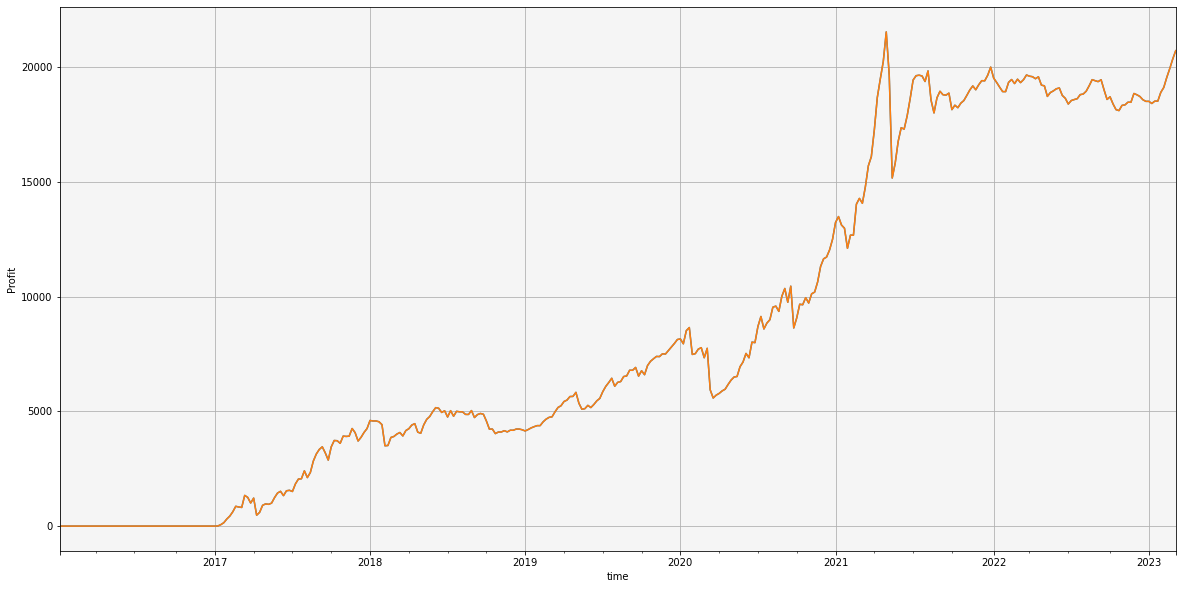

In [23]:
import talib
ERROR = []
trr = pd.DataFrame()
pz = pd.DataFrame()

for x in tqdm(SKTCRI):
    
    DDW[str(x)]['MAX52'] = DDW[str(x)]["還原收盤價"].rolling(52).max()
    DDW[str(x)]["MAX52S"] = DDW[str(x)]["MAX52"].shift(1)
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    KPBS = 0
    KPBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]["還原收盤價"].iloc[z]  > DDW[str(x)]["MAX52S"].iloc[z] and  DDW[str(x)]["成交金額(千)"].iloc[z] > 50000 and  DDW[str(x)]["資使用率"].iloc[z] < 15 \
        and DDW[str(x)]["成交金額(千)"].shift(1).iloc[z] > 20000  :
        
            KPBS = 1

        elif DDW[str(x)]["4MA"].iloc[z] < DDW[str(x)]["4MAS"].iloc[z] and DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['最低價'].rolling(5).min().shift(1).iloc[z] :
            KPBS = 0
            #buy.append("0")
        KPBUY.append(KPBS)
    DDW[str(x)]["KPBUY"] = KPBUY
    DDW[str(x)]["KPBUYS"] = DDW[str(x)]["KPBUY"].shift(1)
    pzb = DDW[str(x)]["KPBUYS"]  
    pzb.name = str(x)
    pzbs = DDW[str(x)]["KPBUY"]
    pzbs.name = str(x)
    DDW[str(x)]["KPRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["KPBUYS"].dropna().astype(int)
    PT = DDW[str(x)]["KPRR"]
    PT.name = str(x)
    if len(trr) == 0:
        trr = PT
    else:
        trr = pd.merge(trr,PT,left_on = trr.index,right_on = PT.index,how = 'outer')
        trr.set_index('key_0',inplace = True)
    if len(pz) == 0:
        pz = pzbs
    else:
        pz = pd.merge(pz,pzbs,left_on = pz.index,right_on = pzbs.index,how = 'outer')
        pz.set_index('key_0',inplace = True)

trrb =trr.sort_index().sum(axis = 1).cumsum().plot(figsize=(20, 10),grid = True)


trrb =trr.sort_index().sum(axis = 1).cumsum().plot(figsize=(20, 10),grid = True)

plt.xlabel("time")
plt.ylabel("Profit")

**<font  size=7>整理多單買賣訊01值</font>**

130.472
0.0
491.0


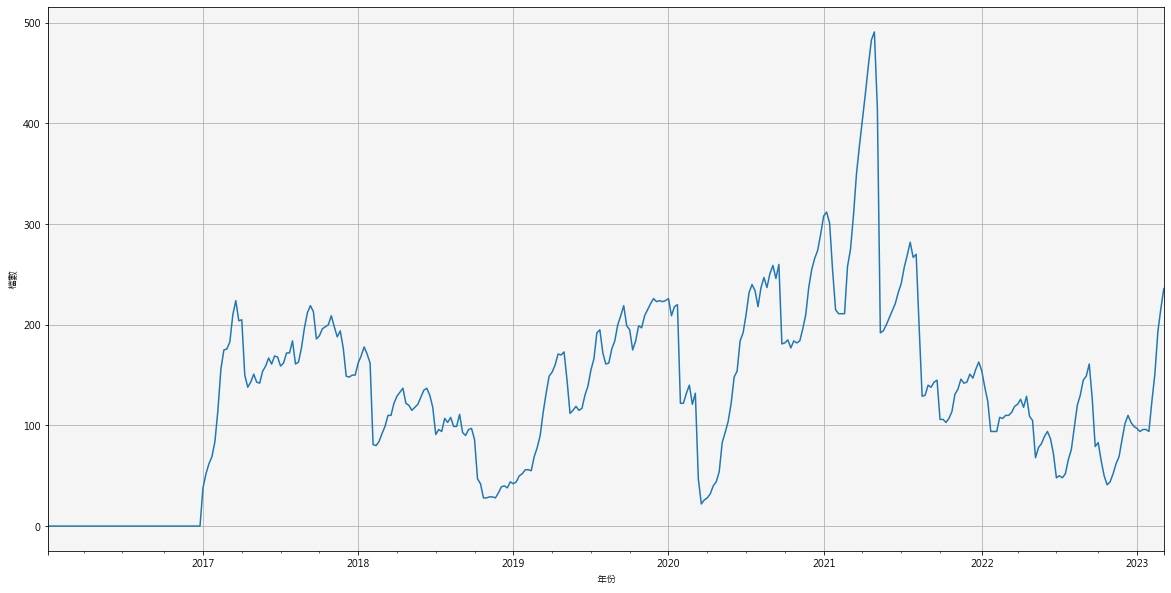

In [136]:
pz1 = pz.sort_index()
f = lambda x :float(x)
pz2 = pz1.applymap(f)
pz3 = pz2.sum(axis=1)
pz4 = pz3.groupby(pd.Grouper(freq='1W')).tail(1)
plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
print(pz4.mean())
print(pz4.min())
print(pz4.max())
pz4.plot(figsize=(20, 10),grid = True)
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('多方部位變化表.png')

**<font  size=7>填寫資料更新日期</font>**

In [137]:
當週日期 = trr.index[-1]
前週日期 = trr.index[-2]

**<font  size=7>關鍵點當週買進部位</font>**

In [139]:
關鍵點持有部位 = pz2.loc[當週日期][(pz2.loc[當週日期]==1)]
關鍵點買進 = pz2.loc[當週日期][(pz2.loc[當週日期]==1) & (pz2.loc[前週日期]==0)]
關鍵點賣出 = pz2.loc[當週日期][(pz2.loc[當週日期]==0) & (pz2.loc[前週日期]==1)]
print("關鍵點買進標的")
print(關鍵點買進)
print("關鍵點買進檔數" , len(關鍵點買進))
print("關鍵點持有部位數目" , len(關鍵點持有部位))
print("關鍵點賣出部位")
print(關鍵點賣出)
print("關鍵點賣出檔數" , len(關鍵點賣出))

關鍵點買進標的
1504    1.0
1540    1.0
1580    1.0
2049    1.0
2066    1.0
2206    1.0
2345    1.0
2376    1.0
2377    1.0
2472    1.0
2926    1.0
3005    1.0
3008    1.0
3038    1.0
3093    1.0
3380    1.0
5225    1.0
5607    1.0
6176    1.0
6548    1.0
Name: 2023-03-10 00:00:00, dtype: float64
關鍵點買進檔數 20
關鍵點持有部位數目 236
關鍵點賣出部位
Series([], Name: 2023-03-10 00:00:00, dtype: float64)
關鍵點賣出檔數 0


**<font  size=7>關鍵點歷年損益</font>**

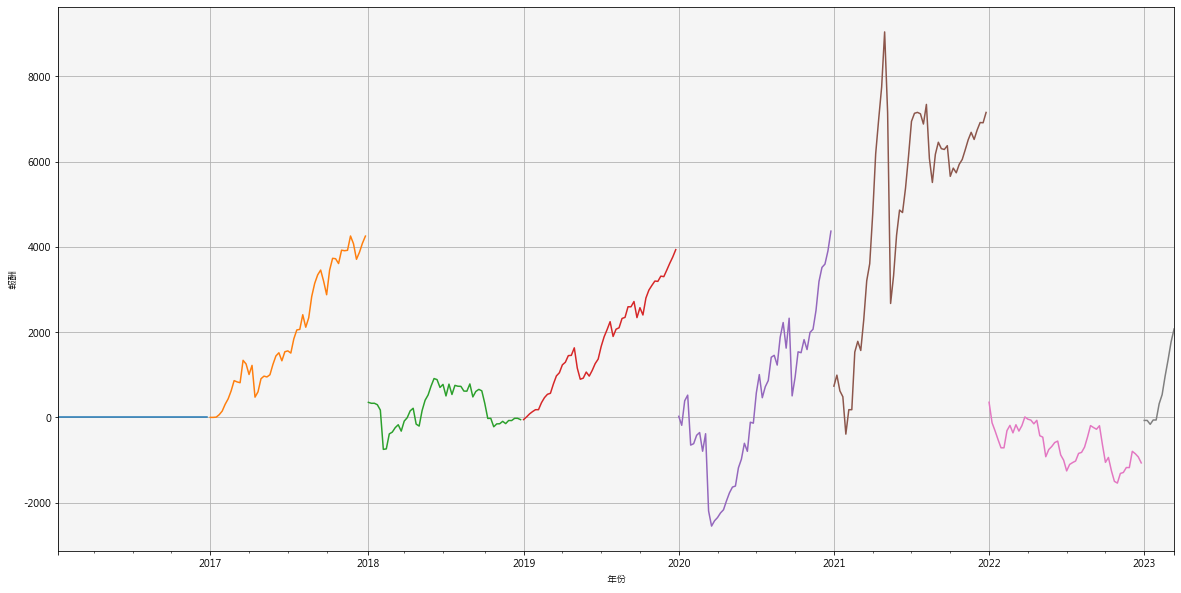

In [144]:
yl = ['2016','2017','2018','2019','2020','2021','2022','2023']
for h in yl :
    trrt = trr.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtfig = trrt.plot(figsize=(20, 10),grid = True)
trrtfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfig.savefig('關鍵點歷年損益.png')

**<font  size=7>放空補丁策略</font>**

100%|██████████| 1098/1098 [02:39<00:00,  6.88it/s]


<AxesSubplot: xlabel='key_0'>

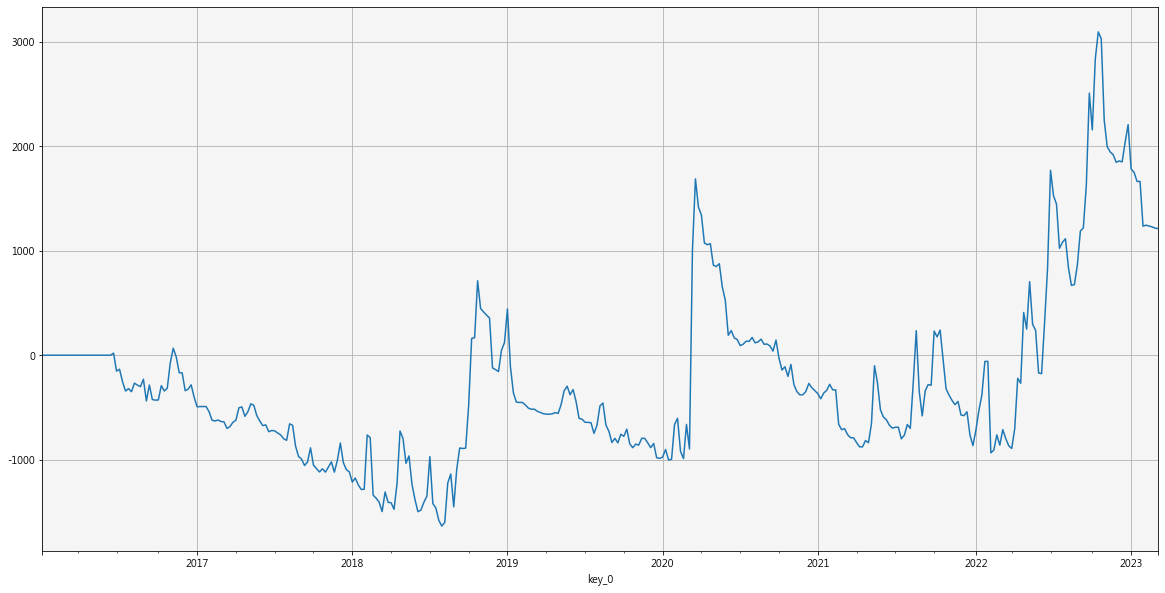

In [145]:
import talib
ERROR = []
trrs = pd.DataFrame()
pzs = pd.DataFrame()

for x in tqdm(SKTCRI):
    
    DDW[str(x)]['LOW5'] = DDW[str(x)]["收盤價"].rolling(2).min()
    DDW[str(x)]['SMAX3'] = DDW[str(x)]["最高價"].rolling(2).max()
    DDW[str(x)]["LOW5S"] = DDW[str(x)]["LOW5"].shift(1)
    DDW[str(x)]["4SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=4, matype=0)
    DDW[str(x)]["COVERMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=7, matype=0)
    DDW[str(x)]["SCHECKMA"] = talib.MA(DDW[str(x)]["收盤價"].dropna(), timeperiod=20, matype=0)
    DDW[str(x)]["4SELLMAS"] = DDW[str(x)]["4SELLMA"].shift(1)
    DDW[str(x)]["30SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=20, matype=0)
    DDW[str(x)]["60SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=20, matype=0)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    DDW['TWA00']['4SELLHMA'] = talib.MA(DDW['TWA00']["收盤價"].dropna(), timeperiod=2, matype=0)
    DDW['TWA00']['20SELLHMA'] = talib.MA(DDW['TWA00']["收盤價"].dropna(), timeperiod=20, matype=0)
    DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    BSS = 0
    SELL =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]['成交金額(千)'].iloc[z] > 100000 and DDW[str(x)]["30SELLMA"].iloc[z] < DDW[str(x)]["30SELLMA"].shift(1).iloc[z] \
        and DDW[str(x)]["還原收盤價"].iloc[z]  <  DDW[str(x)]["60SELLMA"].iloc[z] and DDW[str(x)]["SCHECKMA"].iloc[z] < DDW[str(x)]["SCHECKMA"].shift(4).iloc[z]\
        and DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['LOW5S'].iloc[z]  and DDW[str(x)]['資使用率'].iloc[z] > 3 and DDW[str(x)]['融資維持率(%)'].iloc[z] > 140 :
         
            BSS = -1

        elif   (DDW[str(x)]['還原收盤價'].iloc[z] > DDW[str(x)]['COVERMA'].iloc[z] and DDW[str(x)]['COVERMA'].iloc[z] > DDW[str(x)]['COVERMA'].shift(1).iloc[z]) \
         or DDW[str(x)]['融資維持率(%)'].iloc[z] < 130 or DDW[str(x)]['還原收盤價'].iloc[z] > DDW[str(x)]["COVERMA"].iloc[z] :
            BSS = 0
        # or 
        #DDW[str(x)]['收盤價'].iloc[z] > DDW[str(x)]['最高價'].shift(4).iloc[z] or
        #if  DDW['TWA00']['4SELLHMA'].iloc[z] > DDW['TWA00']['20SELLHMA'].iloc[z]  :
            #BSS = 0
            
        SELL.append(BSS)
    DDW[str(x)]["SELL"] = SELL
    DDW[str(x)]["SELLS"] = DDW[str(x)]["SELL"].shift(1)
    ps = DDW[str(x)]["SELLS"]  
    ps.name = str(x)
    pss = DDW[str(x)]["SELL"]
    pss.name = str(x)
    DDW[str(x)]["SRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["SELLS"].dropna().astype(int)
    PTS = DDW[str(x)]["SRR"]
    PTS.name = str(x)
    if len(trrs) == 0:
        trrs = PTS
    else:
        trrs = pd.merge(trrs,PTS,left_on = trrs.index,right_on = PTS.index,how = 'outer')
        trrs.set_index('key_0',inplace = True)
    if len(pzs) == 0:
        pzs = pss
    else:
        pzs = pd.merge(pzs,pss,left_on = pzs.index,right_on = pss.index,how = 'outer')
        pzs.set_index('key_0',inplace = True)

trrsp = trrs.sort_index().sum(axis = 1).cumsum()
trrsp.plot(figsize=(20, 10),grid = True)

**<font  size=7>整理空單買賣訊01值</font>**

-50.304
-150.0
0.0


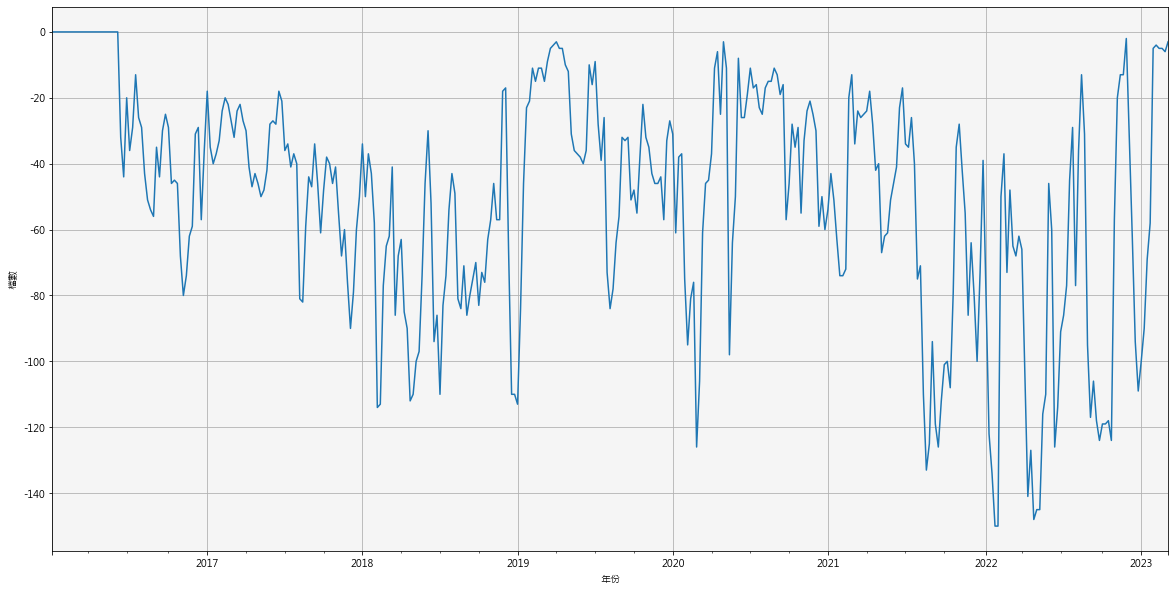

In [146]:
pzs1 = pzs.sort_index()
f1 = lambda x :float(x)
pzs2 = pzs1.applymap(f1)
pzs3 = pzs2.sum(axis=1)
pzs4 = pzs3.groupby(pd.Grouper(freq='1W')).tail(1)
print(pzs4.mean())
print(pzs4.min())
print(pzs4.max())
pzs4.plot(figsize=(20, 10),grid = True)
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('空方部位變化表.png')
pzs4.to_excel('空單部位變化.xlsx')

In [288]:
px.line(pzs4)

**<font  size=7>空單當週放空部位</font>**

In [147]:
空單放空部位 = pzs2.loc[當週日期][(pzs2.loc[當週日期]== -1)]
空單放空 = pzs2.loc[當週日期][(pzs2.loc[當週日期]== -1) & (pzs2.loc[前週日期]==0)]
空單回補 = pzs2.loc[當週日期][(pzs2.loc[當週日期]==0) & (pzs2.loc[前週日期]==-1)]
print("空單放空標的")
print(空單放空)
print("空單放空檔數" , len(空單放空))
print("空單持有空單部位數目" , len(空單放空部位))
print("空單回補部位")
print(空單回補)
print("空單回補檔數" , len(空單回補))

空單放空標的
Series([], Name: 2023-03-10 00:00:00, dtype: float64)
空單放空檔數 0
空單持有空單部位數目 3
空單回補部位
1319    0.0
1536    0.0
2312    0.0
Name: 2023-03-10 00:00:00, dtype: float64
空單回補檔數 3


**<font  size=7>空單歷年損益</font>**

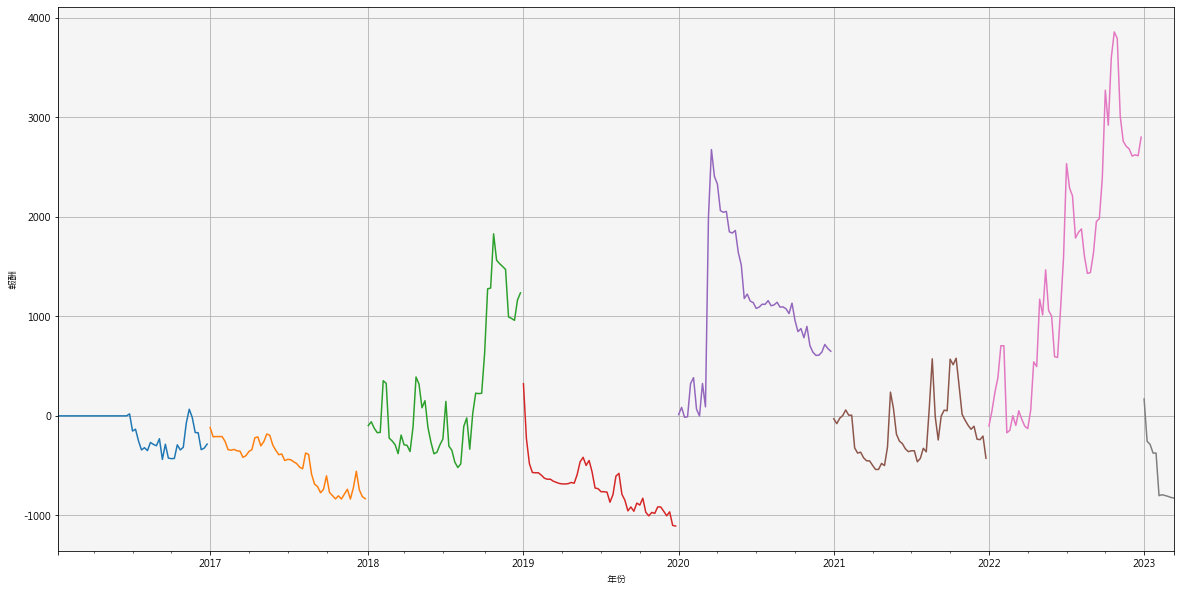

In [150]:
yl = ['2016','2017','2018','2019','2020','2021','2022','2023']
for h in yl :
    trrts = trrs.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtsfig = trrts.plot(figsize=(20, 10),grid = True)
trrtsfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfig.savefig('空單歷年損益.png')

In [274]:
yl = ['2016','2017','2018','2019','2020','2021','2022','2023']
trrtall = pd.Series()
for h in yl :
    trrts = trrs.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtall = pd.concat([trrtall,trrts])
trrtall = pd.DataFrame(trrtall)

In [275]:
trrtall = trrtall.reset_index(drop = False)
trrtall = trrtall.rename(columns = {'index':'datetime',0:'returns'})

In [281]:
trrtall['2016'] = np.where(trrtall.datetime<'2017-01-01',trrtall['returns'],np.nan)
trrtall['2017'] = np.where(((trrtall.datetime<'2018-01-01') & (trrtall.datetime>='2017-01-01')),trrtall['returns'],np.nan)
trrtall['2018'] = np.where(((trrtall.datetime<'2019-01-01') & (trrtall.datetime>='2018-01-01')),trrtall['returns'],np.nan)
trrtall['2019'] = np.where(((trrtall.datetime<'2020-01-01') & (trrtall.datetime>='2019-01-01')),trrtall['returns'],np.nan)
trrtall['2020'] = np.where(((trrtall.datetime<'2021-01-01') & (trrtall.datetime>='2020-01-01')),trrtall['returns'],np.nan)
trrtall['2021'] = np.where(((trrtall.datetime<'2022-01-01') & (trrtall.datetime>='2021-01-01')),trrtall['returns'],np.nan)
trrtall['2022'] = np.where(((trrtall.datetime<'2023-01-01') & (trrtall.datetime>='2022-01-01')),trrtall['returns'],np.nan)
trrtall['2023'] = np.where(((trrtall.datetime<'2024-01-01') & (trrtall.datetime>='2023-01-01')),trrtall['returns'],np.nan)


In [287]:
px.line(trrtall, x = 'datetime', y= yl)

**<font  size=7>台積電策略</font>**

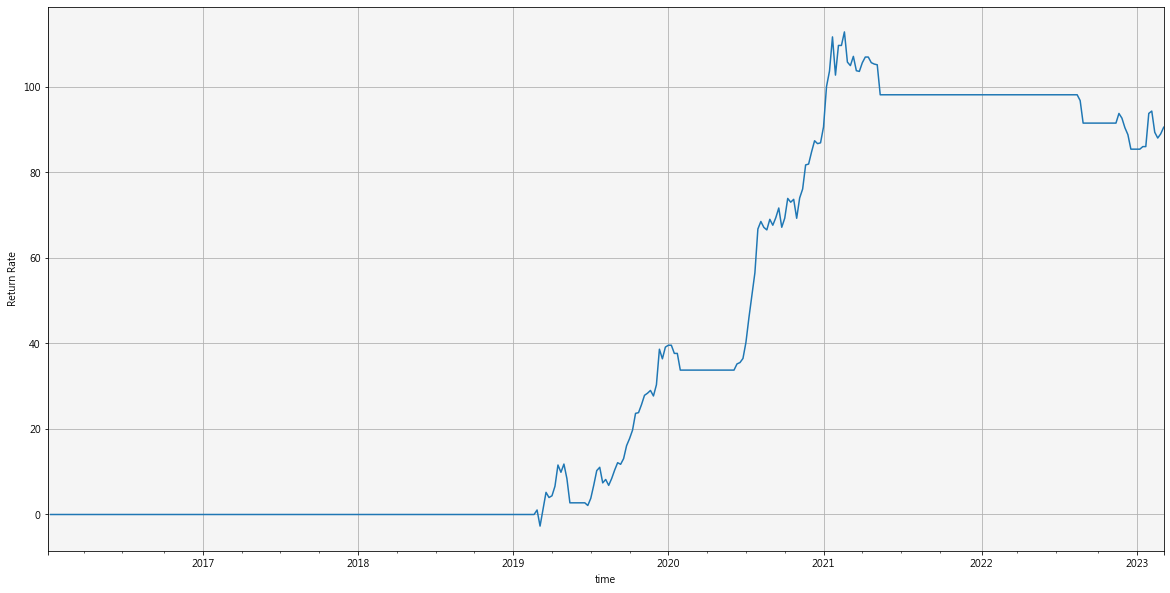

In [151]:
import talib
ERROR = []
trr2330 = pd.DataFrame()
pz2330 = pd.DataFrame()


    
DDW['2330']['MAXN2330'] = DDW['2330']["還原收盤價"].rolling(4).max()
DDW['2330']["MAXNS"] = DDW['2330']["MAXN2330"].shift(1)
DDW['2330']['MINN2330'] = DDW['2330']["還原收盤價"].rolling(4).min()
DDW['2330']["MINNS"] = DDW['2330']["MINN2330"].shift(1)
DDW['2330']["2330MA"] = talib.MA(DDW['2330']["還原收盤價"].dropna(), timeperiod=20, matype=0)
DDW['2330']["2330SMA"] = DDW['2330']["2330MA"].shift(1)
DDW['2330']["2330LMA"] = talib.MA(DDW['2330']["還原收盤價"].dropna(), timeperiod=20, matype=0)
DDW['2330']["DR"] = ((DDW['2330']["還原收盤價"] - DDW['2330']["還原收盤價"].shift(1))/DDW['2330']["還原收盤價"].shift(1))*100
DDW['TWA00']['4SHMA'] = talib.MA(DDW['TWA00']["sharpe"].dropna(), timeperiod=4, matype=0)
DDW['TWA00']['20SHMA'] = talib.MA(DDW['TWA00']["sharpe"].dropna(), timeperiod=20, matype=0)
DDW['2330']['出場價'] = DDW['2330']["最低價"].rolling(4).min().shift(1)
BS2330 = 0
BUY2330 =[]
for z in range(len(DDW['2330'])):

    if  DDW['2330']["還原收盤價"].iloc[z]  >  DDW['2330']["2330MA"].iloc[z] and DDW['2330']['收盤價'].iloc[z] > DDW['2330']['最高價'].rolling(2).max().shift(1).iloc[z] \
    and   DDW['TWA00']['4SHMA'].iloc[z] < 0.3 :
         BS2330 = 1

    elif  DDW['2330']["收盤價"].iloc[z] < DDW['2330']["出場價"].iloc[z]   :
        BS2330 = 0
        
    
        BS2330 = 0
        #buy.append("0")
    BUY2330.append(BS2330)
DDW['2330']["BUY2330"] = BUY2330
DDW['2330']["BUY2330S"] = DDW['2330']["BUY2330"].shift(1)
pz2330 = DDW['2330']["BUY2330S"]  
pz2330.name = '2330'
pzz2330 = DDW['2330']["BUY2330"]
pzz2330.name = '2330'
DDW['2330']["2330RR"] = DDW['2330']["DR"] * DDW['2330']["BUY2330S"].dropna().astype(int)
PTS2330 = DDW['2330']["2330RR"]
PTS2330.name = '2330'
if len(trr2330) == 0:
    trr2330 = PTS2330
else:
    trr2330 = pd.merge(trr2330,PTS2330,left_on = trrs.index,right_on = PTS.index,how = 'outer')
    trr2330.set_index('key_0',inplace = True)

trr2330fig = trr2330.cumsum().plot(figsize=(20, 10),grid = True)
trr2330fig = plt.gcf()
plt.xlabel("time")
plt.ylabel("Return Rate")
trr2330fig.savefig('2330')

In [155]:
px.line(trr2330.cumsum())